## Task 1: Chart Interpretation:

The provided chart shows a combination of price, trend-colored overlays, and oscillator-based signals. Upon inspection, the colored background (green/red) indicates trend direction, while the buy and sell arrows align with short-term price reversals within the trend. The lower panel appears to be a bounded volume-weighted oscillator ranging between 0 and 100, with significant activity around levels 30 and 70. Based on these visual cues, we interpret the chart as a trend-based reversal system that combines a trend-following indicator with an overbought/oversold condition.

We infer the following indicators are used:
- **Supertrend indicator (Heiken Ashi-based)**: Identifies trend direction using price and volatility. Plotted using Heiken Ashi in the chart, but interpreted here using regular candles.
- **Money Flow Index (MFI)**: A volume-weighted oscillator used to identify overbought and oversold conditions.

This setup resembles a common structure used in discretionary trading: only trade in the direction of the trend, and time entries using volume-confirmed reversals. Therefore, the strategy logic appears to use:
- **Buy signals**: When the Supertrend is green (uptrend) and MFI < 30 (oversold).
- **Sell signals**: When the Supertrend is red (downtrend) and MFI > 70 (overbought).

## Task 2: Entry and Exit Rules

Based on the Chart Analysis, we now define entry and exit rules using the combination of Supertrend and MFI.

**Entry Rules:**
- **Buy (Long)**:
  - Supertrend is green (indicating an uptrend)
  - MFI is below 30 (indicating the price is oversold within the uptrend)
- **Sell (Short)**:
  - Supertrend is red (indicating a downtrend)
  - MFI is above 70 (indicating the price is overbought within the downtrend)

**Exit Rules:**
- **Exit Long Position** if:
  - MFI rises above 70 (now overbought), or
  - Supertrend flips to red (trend reversal), or
  - An opposite (short) signal appears
- **Exit Short Position** if:
  - MFI falls below 30 (now oversold), or
  - Supertrend flips to green (trend reversal), or
  - An opposite (long) signal appears


## Task 3: Strategy Implementation and Backtest:

### Strategy Implementation

In [51]:
# Robust download for column formats
def robust_download(ticker, start, end, interval="1d"):
    df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)

    # Flatten multi-level column
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.reset_index(inplace=True)
    df.columns = [col.lower() for col in df.columns]

    if 'date' in df.columns:
        df.rename(columns={'date': 'datetime'}, inplace=True)
    elif 'datetime' not in df.columns:
        df.rename(columns={df.columns[0]: 'datetime'}, inplace=True)

    df['datetime'] = pd.to_datetime(df['datetime'])
    return df

data = robust_download("CAMS.NS", start="2024-01-01", end="2025-05-04")
print(data.columns.tolist())  # Show column names again


['datetime', 'close', 'high', 'low', 'open', 'volume']


In [55]:
# Add Supertrend based on clean OHLC data
def add_supertrend(df, period=10, multiplier=3):
    hl2 = (df['high'] + df['low']) / 2

    tr = pd.concat([
        df['high'] - df['low'],
        abs(df['high'] - df['close'].shift()),
        abs(df['low'] - df['close'].shift())
    ], axis=1).max(axis=1)

    atr = tr.rolling(window=period).mean()

    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)

    supertrend = [True]  # Start with uptrend
    for i in range(1, len(df)):
        if df['close'][i] > upperband[i - 1]:
            supertrend.append(True)
        elif df['close'][i] < lowerband[i - 1]:
            supertrend.append(False)
        else:
            supertrend.append(supertrend[i - 1])

    df['atr'] = atr
    df['supertrend'] = supertrend
    return df

# Apply it to your data
data = add_supertrend(data)

# Confirm result
data[['datetime', 'close', 'supertrend']].tail()


,datetime,close,supertrend
323,2025-04-25,3938.100098,True
324,2025-04-28,3944.100098,True
325,2025-04-29,3999.800049,True
326,2025-04-30,3906.300049,True
327,2025-05-02,3841.000000,True


In [56]:
# Add MFI (Money Flow Index)
def add_mfi(df, period=14):
    tp = (df['high'] + df['low'] + df['close']) / 3  # typical price
    mf = tp * df['volume']  # raw money flow

    pos_flow = [0]
    neg_flow = [0]
    for i in range(1, len(tp)):
        if tp[i] > tp[i - 1]:
            pos_flow.append(mf[i])
            neg_flow.append(0)
        else:
            pos_flow.append(0)
            neg_flow.append(mf[i])

    pos_mf = pd.Series(pos_flow).rolling(period).sum()
    neg_mf = pd.Series(neg_flow).rolling(period).sum()

    mfi = 100 * (pos_mf / (pos_mf + neg_mf + 1e-6))  # add small constant to avoid division by zero
    df['mfi'] = mfi
    return df

# Apply MFI to the data
data = add_mfi(data)

# Check last few values
data[['datetime', 'close', 'mfi']].tail()


,datetime,close,mfi
323,2025-04-25,3938.100098,64.861586
324,2025-04-28,3944.100098,60.430352
325,2025-04-29,3999.800049,67.073185
326,2025-04-30,3906.300049,69.487565
327,2025-05-02,3841.000000,65.362391


In [57]:
# Generate Buy/Sell Signals for Strategy X
data['signal'] = 0

for i in range(1, len(data)):
    if data.loc[i, 'supertrend'] and data.loc[i, 'mfi'] < 30:
        data.loc[i, 'signal'] = 1  # Buy
    elif not data.loc[i, 'supertrend'] and data.loc[i, 'mfi'] > 70:
        data.loc[i, 'signal'] = -1  # Sell

print("Buy signals:", (data['signal'] == 1).sum())
print("Sell signals:", (data['signal'] == -1).sum())

Buy signals: 3
Sell signals: 0


### Backtesting

In [58]:
# Backtesting for Strategy X
in_position = False
position = None
entry_price = 0
returns = []

for i in range(1, len(data)):
    signal = data.loc[i, 'signal']

    if not in_position:
        if signal == 1:
            in_position = True
            position = 'long'
            entry_price = data.loc[i, 'close']
        elif signal == -1:
            in_position = True
            position = 'short'
            entry_price = data.loc[i, 'close']

    elif in_position:
        mfi = data.loc[i, 'mfi']
        trend = data.loc[i, 'supertrend']

        if position == 'long' and (mfi > 70 or not trend or signal == -1):
            exit_price = data.loc[i, 'close']
            returns.append((exit_price - entry_price) / entry_price)
            in_position = False

        elif position == 'short' and (mfi < 30 or trend or signal == 1):
            exit_price = data.loc[i, 'close']
            returns.append((entry_price - exit_price) / entry_price)
            in_position = False

# Summary of results
total_trades = len(returns)
winning_trades = sum(1 for r in returns if r > 0)
avg_return = np.mean(returns) * 100 if total_trades > 0 else 0
win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0

print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Average Return per Trade: {avg_return:.2f}%")


Total Trades: 2
Winning Trades: 1
Win Rate: 50.00%
Average Return per Trade: 3.70%


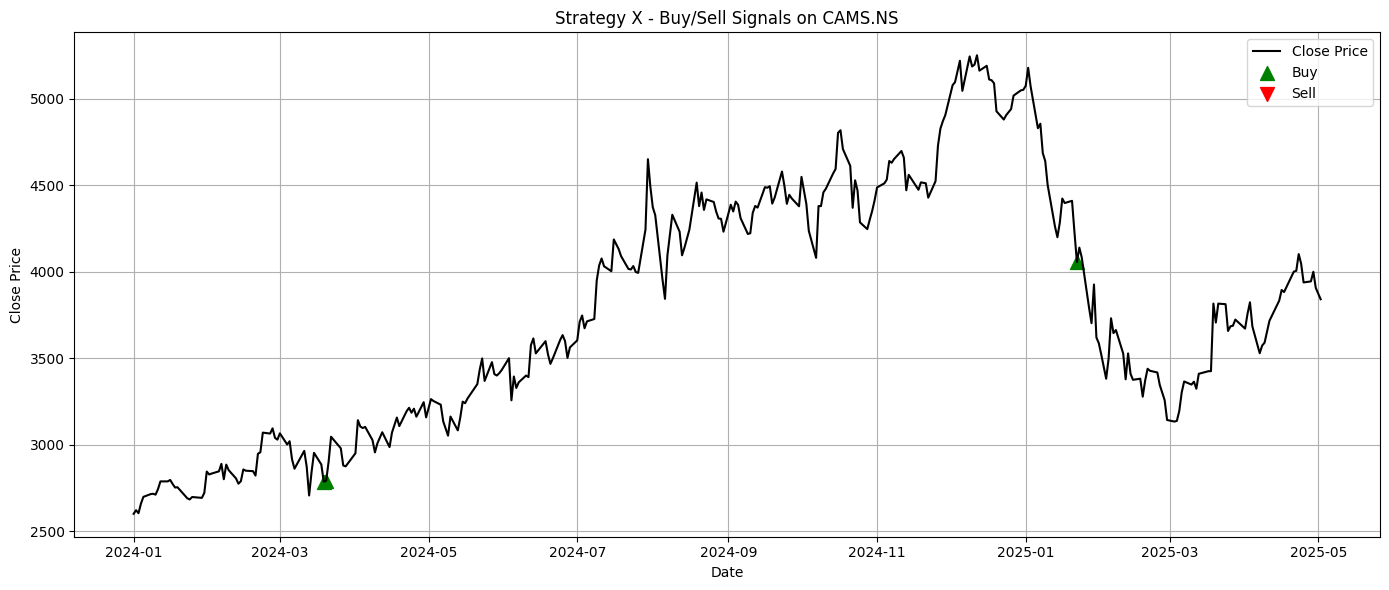

In [59]:
# Plot Buy/Sell signals on the chart
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]

plt.figure(figsize=(14, 6))
plt.plot(data['datetime'], data['close'], label='Close Price', color='black')

# Plot buy and sell points
plt.scatter(buy_signals['datetime'], buy_signals['close'], marker='^', color='green', label='Buy', s=100)
plt.scatter(sell_signals['datetime'], sell_signals['close'], marker='v', color='red', label='Sell', s=100)

plt.title("Strategy X - Buy/Sell Signals on CAMS.NS")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Task 4: Incorporating a Complementary Indicator:

### Explanation and Defination of Strategy Y

Strategy Y is an improvement over Strategy X as it introduces a filter based on volatility with the Average True Range (ATR). The new indicator accompanies Supertrend and MFI in that it ensures that only during times of adequate price action are trades taken. While Supertrend identifies direction of trend and MFI tells us when the market is overbought or oversold, ATR assists in verifying that the market is as active as it should be to accommodate significant price action.

Without volatility checking, Strategy X would produce signals in low-volatility or flat markets, and these usually result in false breakouts or small, losing moves. By insisting that ATR > ATR_MA, Strategy Y removes these poor setups and makes the trades more reliable.

Thus, Strategy Y is a better Strategy X with the same logic base (Supertrend + MFI), with trades only permitted when the ATR verifies that the market is in good shape. This strengthens the strategy and eliminates most of the false entries in inactive or sideways markets.


### Strategy Y: Extension of Strategy X with Volatility Filter

In [73]:
#  Add ATR and ATR Moving Average
def add_atr_filter(df, period=14):
    high_low = df['high'] - df['low']
    high_close = abs(df['high'] - df['close'].shift())
    low_close = abs(df['low'] - df['close'].shift())

    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()

    df['atr'] = atr
    df['atr_ma'] = atr.rolling(window=period).mean()
    return df

# Add to data
data = add_atr_filter(data)
data[['datetime', 'atr', 'atr_ma']].tail()


,datetime,atr,atr_ma
323,2025-04-25,151.314296,150.711208
324,2025-04-28,145.821446,150.820905
325,2025-04-29,140.050014,150.466317
326,2025-04-30,126.007150,147.965044
327,2025-05-02,121.192871,144.276017


In [72]:
# Generate Strategy Y signals (with volatility filter)
data['signal_y'] = 0

for i in range(1, len(data)):
    atr_valid = data.loc[i, 'atr'] > 1.05 * data.loc[i, 'atr_ma']

    if data.loc[i, 'supertrend'] and data.loc[i, 'mfi'] < 30 and atr_valid:
        data.loc[i, 'signal_y'] = 1  # Buy signal

    elif not data.loc[i, 'supertrend'] and data.loc[i, 'mfi'] > 70 and atr_valid:
        data.loc[i, 'signal_y'] = -1  # Sell signal

# To Print Buy and Sell Signals
print("Buy signals (Y):", (data['signal_y'] == 1).sum())
print("Sell signals (Y):", (data['signal_y'] == -1).sum())

Buy signals (Y): 3
Sell signals (Y): 0


In [71]:
# Backtesting Strategy Y
in_position = False
position = None
entry_price = 0
returns_y = []

for i in range(1, len(data)):
    signal = data.loc[i, 'signal_y']

    if not in_position:
        if signal == 1:
            in_position = True
            position = 'long'
            entry_price = data.loc[i, 'close']
        elif signal == -1:
            in_position = True
            position = 'short'
            entry_price = data.loc[i, 'close']

    elif in_position:
        mfi = data.loc[i, 'mfi']
        trend = data.loc[i, 'supertrend']

        if position == 'long' and (mfi > 70 or not trend or signal == -1):
            exit_price = data.loc[i, 'close']
            returns_y.append((exit_price - entry_price) / entry_price)
            in_position = False

        elif position == 'short' and (mfi < 30 or trend or signal == 1):
            exit_price = data.loc[i, 'close']
            returns_y.append((entry_price - exit_price) / entry_price)
            in_position = False

# Summary of Strategy Y
total_trades_y = len(returns_y)
winning_trades_y = sum(1 for r in returns_y if r > 0)
avg_return_y = np.mean(returns_y) * 100 if total_trades_y > 0 else 0
win_rate_y = (winning_trades_y / total_trades_y) * 100 if total_trades_y > 0 else 0

print(f"Strategy Y - Total Trades: {total_trades_y}")
print(f"Strategy Y - Winning Trades: {winning_trades_y}")
print(f"Strategy Y - Win Rate: {win_rate_y:.2f}%")
print(f"Strategy Y - Avg Return per Trade: {avg_return_y:.2f}%")

Strategy Y - Total Trades: 2
Strategy Y - Winning Trades: 1
Strategy Y - Win Rate: 50.00%
Strategy Y - Avg Return per Trade: 3.70%


##Task 5: Strategy Enhancements:


Strategy X (and Strategy Y) is a reversal-based strategy that works best in trending conditions with clean pullbacks. However, it may underperform in certain types of market regimes. These include sideways, low-volume, or low-volatility conditions, as well as during sudden price crashes. In such cases, the indicators used (Supertrend and MFI) may give unreliable or delayed signals.

### Market Regimes Where Strategy May Underperform
- **Sideways / Choppy Markets**: Supertrend changes often, resulting in false buy and sell signals.
- **Low Volume Conditions**: MFI becomes noisy or unstable, which can result in misleading oversold/overbought signals.
- **Sudden Crashes**: MFI stays low, and Supertrend lags, so short entries are never triggered—even though price is collapsing.
- **Low Volatility**: Price remains stuck within narrow bands; neither Supertrend nor MFI generates valid signals.

### Proposed modifications to Improve Performance

To address these weaknesses, the following modifications are proposed:

- Use **RSI confirmation** to validate trend strength in sideways markets.
- Apply a **minimum volume threshold** to ignore signals on illiquid or inactive days.
- Allow **short entries on Supertrend flip alone**, especially during crash-like breakdowns.
- Use an **ATR-based filter** (like ATR > ATR_MA) to ensure signals only occur during active market phases (already done in Strategy Y).
- Add a **1-candle confirmation** delay after a Supertrend flip to reduce whipsaw trades.